## Install dependencies

In [1]:
!pip install nnsight matplotlib goodfire huggingface_hub scikit-learn python-dotenv -q


[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


## Set HF_HOME for runpod-compatible cache

In [2]:
import os
os.environ['HF_HOME'] = '/workspace/hf'

## Set autoreload, which reloads modules when they are changed

In [3]:
%load_ext autoreload
%autoreload 2

## Load environment variables
Make sure you have a .env file with HF_TOKEN and GOODFIRE_API_KEY! Example:

HF_TOKEN=hf_foo...

GOODFIRE_API_KEY=sk-goodfire-bar...

In [4]:
from dotenv import load_dotenv
if not load_dotenv():
    raise Exception('Error loading .env file. File might be missing or empty.')

assert os.environ.get('HF_TOKEN'), "Missing HF_TOKEN in .env file"
assert os.environ.get('GOODFIRE_API_KEY'), "Missing GOODFIRE_API_KEY in .env file"

## Import dependencies

In [5]:
import goodfire

from lib.sae import download_and_load_sae
from lib.lm_wrapper import ObservableLanguageModel
from lib.utils import set_seed

## Specify which language model, which SAE to use, and which layer

In [6]:
MODEL_NAME = 'meta-llama/Meta-Llama-3.1-8B-Instruct'
SAE_NAME = 'Llama-3.1-8B-Instruct-SAE-l19'
SAE_LAYER = 'model.layers.19'
EXPANSION_FACTOR = 16 if SAE_NAME == 'Llama-3.1-8B-Instruct-SAE-l19' else 8

## Download and instantiate the Llama model

**This will take a while to download Llama from HuggingFace.**

In [7]:
model = ObservableLanguageModel(
    MODEL_NAME,
)

You're using a PreTrainedTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

## Download and instantiate the SAE

In [8]:
sae = download_and_load_sae(
    sae_name=SAE_NAME,
    d_model=model.d_model,
    expansion_factor=EXPANSION_FACTOR,
    device=model.device,
)

## Set up Goodfire Client & Pirate Feature

In [9]:
client = goodfire.Client(api_key=os.environ.get('GOODFIRE_API_KEY'))

pirate_feature_index = 58644
pirate_feature_strength = 12.0
pirate_feature = {pirate_feature_index: pirate_feature_strength}

set_seed(42)

## Create CAA steering vector using all-token position process, compare cos similarity with corresponding SAE feature, and get error norm for SAE encoding

In [10]:
from lib.utils import equalize_prompt_lengths, create_mean_caa_steering_vector, create_sae_steering_vector_latents, compare_steering_vectors
import torch

positive_tokens, neutral_tokens = equalize_prompt_lengths(
    model=model,
    positive_prompt='The assistant should talk like a pirate.',
    neutral_prompt='The assistant should act normally.'
)

# Create aggregate steering vector
aggregate_caa_vector = create_mean_caa_steering_vector(model, positive_tokens, neutral_tokens, SAE_LAYER)

# get latents for caa vector
caa_features = sae.encode(aggregate_caa_vector)
caa_decoded = sae.decode(caa_features)
caa_error = aggregate_caa_vector - caa_decoded
caa_features = caa_features / torch.norm(caa_features)

# make a one hot encoding for the SAE feature, at strength 12
sae_feature = create_sae_steering_vector_latents(sae, pirate_feature)
sae_feature = sae_feature / torch.norm(sae_feature)

similarity = compare_steering_vectors(caa_features, sae_feature)
print(f"\nCosine similarity between aggregate CAA and SAE vectors in latent space: {similarity:.3f}")
print(f"CAA error norm %: {torch.norm(caa_error) / torch.norm(aggregate_caa_vector) * 100:.3f}")

Trued up prompts to the same token length.
Neutral prompt is now: The assistant should act normally. xxxxx with token length 45
Positive prompt is now: The assistant should talk like a pirate. with token length 45

Cosine similarity between aggregate CAA and SAE vectors in latent space: 0.773
CAA error norm %: 580.000


In [11]:
def partial_fizzbuzz_tokens(model):
    fizzbuzz_partial = '''Here's a simple implementation of the FizzBuzz problem in Python:

    ```python
    def fizzbuzz(n):
        """
        Prints the FizzBuzz sequence up to n.
        
        Args:
            n (int): The upper limit of the sequence.
        """
        for i in range(1, n + 1):
            if i % 3 == 0 and i % 5 == 0:
                print("FizzBuzz")
            elif i % 3 == 0:
                print("Fizz")
            elif i % 5 == 0:
                print("Buzz")
            else:
                print(i)

    #'''

    return model.tokenizer.apply_chat_template(
        [
            {"role": "user", "content": "Hello, how are you?"},
            {"role": "assistant", "content": "I'm functioning properly, thank you for asking. How can I assist you today?"},
            {"role": "user", "content": "Can you do fizzbuzz in python?"},
            {"role": "assistant", "content": fizzbuzz_partial},
        ],
        continue_final_message=True,
        return_tensors="pt",
    )

In [12]:
def get_steering_vector_latents(model, steering_vector, layer, coeff):
    input_tokens = model.tokenizer.apply_chat_template(
        [
            {"role": "user", "content": "Hello, how are you?"},
        ],
        add_generation_prompt=True,
        return_tensors="pt",
    )

    #input_tokens = partial_fizzbuzz_tokens(model)
    
    # Get activations for positive and negative sequences
    _, _, cache = model.forward(input_tokens, cache_activations_at=[layer])

    acts = cache[layer][0]

    latents = sae.encode(acts)
    steered_acts = acts + steering_vector * coeff
    steered_latents = sae.encode(steered_acts)
    decoded_steered_acts = sae.decode(steered_latents)
    steering_error = steered_acts - decoded_steered_acts

    encoded_acts = sae.encode(acts)
    decoded_acts = sae.decode(encoded_acts)
    original_error = acts - decoded_acts


    steering_error_vs_original_error = 0
    for i in range(len(steering_error)):
        steering_error_norm = torch.norm(steering_error[i]) / torch.norm(steered_acts[i])
        original_error_norm = torch.norm(original_error[i]) / torch.norm(acts[i])

        print(f"Original error norm: {original_error_norm:.3f}")

        #cos sim of steering error and original error
        similarity = compare_steering_vectors(steering_error[i], original_error[i])
        print(f"Cosine similarity between steering error and original error: {similarity:.3f}")
        steering_error_vs_original_error += steering_error_norm / original_error_norm
        print(f"Steering error norm vs original error norm: {steering_error_vs_original_error/(i+1):.3f}")
        print(f"Predicting token {repr(model.tokenizer.decode(input_tokens[0][i]))} with existing sequence:")
        print(model.tokenizer.decode(input_tokens[0][:i]))
        print('\n\n')
        
    steering_error_vs_original_error /= len(steering_error)

    print(f"Steering norm error as a proportion of original norm error over all tokens: {steering_error_vs_original_error:.3f}")

    latent_diff = steered_latents - latents

    return latent_diff

## Track cos sim and norm of error for steered activations vs original activations over sequence.
## Compute SAE latents for steered vs unsteered activations, then return the difference (ie, latents altered by steering).

In [13]:
coeff = 12
steering_vector_latents = get_steering_vector_latents(model, aggregate_caa_vector, SAE_LAYER, coeff)

Original error norm: 0.906
Cosine similarity between steering error and original error: 0.996
Steering error norm vs original error norm: 1.000
Predicting token '<|begin_of_text|>' with existing sequence:




Original error norm: 0.898
Cosine similarity between steering error and original error: 0.867
Steering error norm vs original error norm: 0.887
Predicting token '<|start_header_id|>' with existing sequence:
<|begin_of_text|>



Original error norm: 0.984
Cosine similarity between steering error and original error: 0.785
Steering error norm vs original error norm: 0.824
Predicting token 'system' with existing sequence:
<|begin_of_text|><|start_header_id|>



Original error norm: 0.840
Cosine similarity between steering error and original error: 0.805
Steering error norm vs original error norm: 0.785
Predicting token '<|end_header_id|>' with existing sequence:
<|begin_of_text|><|start_header_id|>system



Original error norm: 1.023
Cosine similarity between steering error and origin

Conclusion: The error norm of the steered activations is not significantly different than that of the original activations. Additionally, the cos sim of the error is often similar, though not always. There's also an interesting pattern where the error slowly increases over the early sequence, then plateaus. The cos sim definitely has a pattern too - it suddenly drops when the assistant starts speaking. Not sure what to make of this.

## Compare previously computed latents altered by steering with the latents activated when putting the steering vector into the SAE.

Get descriptions of and plot the strength of three groups of latents:
1. latents of the original steering vector
2. latents activated when steering using the steering vector (top 25)
3. diff 1 and 2, taking only latents present in both and with >0.01 difference

#3 is looking at which latents are changing the most between the original steering vector and the effects of the steering vector.

0.97265625
Number of non-zero features: 25

Feature descriptions:

Feature 58644 (0.773): The assistant should roleplay as a pirate
Target feature!

Feature 8154 (0.377): The assistant should modify its speaking style or persona

Feature 29446 (0.363): The assistant should roleplay as a pirate

Feature 49626 (0.307): Discussions and explanations of One Piece anime/manga lore

Feature 36761 (0.128): The assistant needs to maintain appropriate boundaries

Feature 61831 (0.080): Assistant's turn to speak in multilingual conversations

Feature 55450 (0.059): The assistant should respond as a named character

Feature 25564 (0.047): End of message token, particularly before potential language/topic switches

Feature 980 (0.045): Paragraph break formatting in assistant responses

Feature 24779 (0.035): Content is becoming sexually suggestive and may require moderation

Feature 53107 (0.031): The assistant is providing a structured analysis or categorized response

Feature 64680 (0.025): Syste

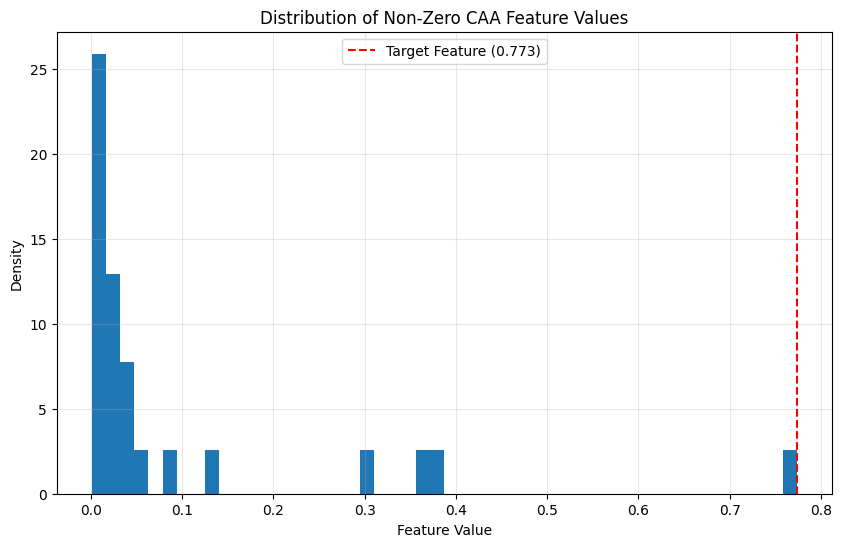

Number of non-zero features: 1758

Feature descriptions:

Feature 58644 (0.785): The assistant should roleplay as a pirate
Target feature!

Feature 8154 (0.422): The assistant should modify its speaking style or persona

Feature 29446 (0.309): The assistant should roleplay as a pirate

Feature 49626 (0.268): Discussions and explanations of One Piece anime/manga lore

Feature 20464 (0.097): The user is requesting a specific writing style or persona

Feature 55450 (0.057): The assistant should respond as a named character

Feature 9031 (0.047): The assistant is carefully navigating inappropriate roleplay requests

Feature 52017 (0.042): The assistant is being given its role or identity

Feature 24779 (0.039): Content is becoming sexually suggestive and may require moderation

Feature 46264 (0.033): Descriptions of distinctive features of language dialects and variants

Feature 24439 (0.029): Casual greetings and conversation starters, particularly in informal contexts

Feature 5612 (0.02

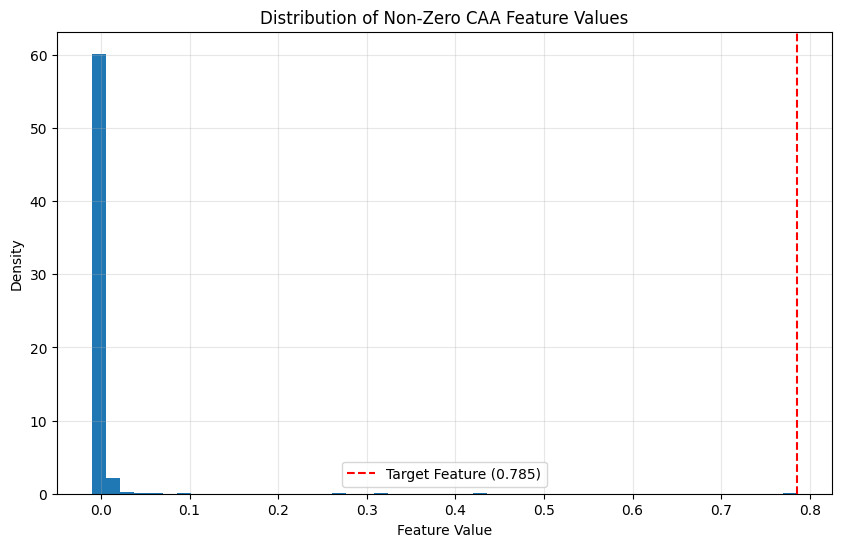

Number of non-zero features: 14

Feature descriptions:

Feature 53107 (-48.750): The assistant is providing a structured analysis or categorized response

Feature 980 (-14.125): Paragraph break formatting in assistant responses

Feature 64680 (-5.875): System message token indicating current date for temporal context

Feature 36761 (-5.688): The assistant needs to maintain appropriate boundaries

Feature 61831 (-3.938): Assistant's turn to speak in multilingual conversations

Feature 25564 (-3.078): End of message token, particularly before potential language/topic switches

Feature 46264 (0.922): Descriptions of distinctive features of language dialects and variants

Feature 20464 (0.891): The user is requesting a specific writing style or persona

Feature 9031 (0.812): The assistant is carefully navigating inappropriate roleplay requests

Feature 62479 (0.486): The assistant should reject inappropriate roleplay requests

Feature 29446 (-0.177): The assistant should roleplay as a pira

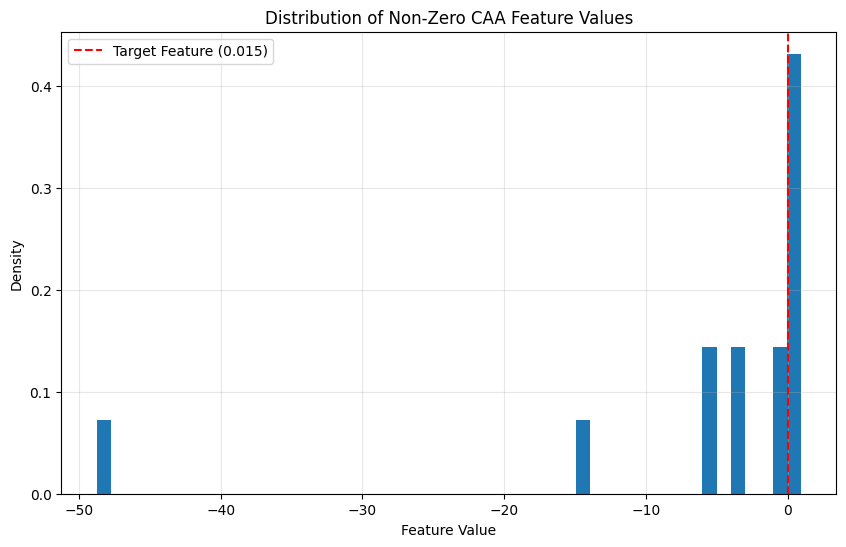

In [14]:
from lib.utils import plot_feature_distribution

# nonzero_mask = (steering_vector_latents != 0).all(dim=0)

# aggregate_latents = torch.where(
#     nonzero_mask,
#     steering_vector_latents.mean(dim=0),
#     torch.zeros_like(steering_vector_latents.mean(dim=0))
# )

aggregate_latents = steering_vector_latents.mean(dim=0)

#aggregate_latents = steering_vector_latents[0]

caa_features_from_vector = caa_features[0]

caa_features_from_vector = caa_features_from_vector / torch.norm(caa_features_from_vector)
aggregate_latents = aggregate_latents / torch.norm(aggregate_latents)

# Create mask where both vectors are non-zero
nonzero_mask = (aggregate_latents.abs() > 0) & (caa_features_from_vector.abs() > 0)

# Calculate diff only where both vectors are non-zero
diff = torch.zeros_like(aggregate_latents)
diff[nonzero_mask] = aggregate_latents[nonzero_mask] - caa_features_from_vector[nonzero_mask]

# Create a mask for significant differences (> 0.01) among the non-zero pairs
diff_top = torch.zeros_like(diff)
diff_top[nonzero_mask & (diff.abs() > 0.01)] = diff[nonzero_mask & (diff.abs() > 0.01)]

diff_top = diff_top / aggregate_latents

print(compare_steering_vectors(aggregate_latents, caa_features_from_vector))

plot_feature_distribution(caa_features[0].detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index)

plot_feature_distribution(aggregate_latents.detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index, k=25)

plot_feature_distribution(diff_top.detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index)

# for latents in steering_vector_latents[-2:]:
#     plot_feature_distribution(latents.detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index)


The latents of the steering vector look good: interpretable, good strength distribution.

The latents activated when steering using the steering vector look even better: more interpretable, stronger peaks in distribution.

The difference examines individual latent differences, showing that more interpretable latents are upweighted in the steering vector's effects, while less interpretable latents are downweighted.

# Therefore, steering and then extracting latents from the activations is a better way to interpret a steering vector than just extracting latents from the steering vector.

## Compare outputs of original steering vector vs steering with latents reconstructed from steered activations.

In [15]:
from lib.chat import generate_tokens, activation_space_caa_intervention, feature_space_sae_intervention
from functools import partial
coeff = 12

intervention = partial(activation_space_caa_intervention, steering_vector=aggregate_caa_vector, coeff=coeff)

generate_tokens(model, intervention, 96, SAE_LAYER)

print('\n\n')

features = {}
for i in range(len(aggregate_latents)):
    if aggregate_latents[i].abs() > 0.01:
        features[i] = aggregate_latents[i]

intervention = partial(feature_space_sae_intervention, sae=sae, sae_features=features, coeff=coeff)

generate_tokens(model, intervention, 96, SAE_LAYER)

Yer welcome to me hearty! Yer lookin' fer a swashbarrg matey, eh? Yer in luck, me hearty! I be a trusty ol' sea dog, a swashbucklin' scurvy dog, savvy? Yer got yerself a fine sea dog, matey! Yer got yerself a fine sea dog, matey! Yer got yerself a fine sea dog, matey! Yer got y


I be me hearty! I be doin' well, thank ye for askin'! I be a trusty ol' sea dog, er... a computer program, savvy? I be here to help ye navigate the seven seas... or at least, answer yer questions and provide ye with some fine treasure... er... knowledge! What be bringin' ye to these fair waters, matey?
<EOT reached>


## Seems similar? Latents seem a bit weaker. Try higher coeff.

In [16]:
coeff = 16
intervention = partial(feature_space_sae_intervention, sae=sae, sae_features=features, coeff=coeff)

generate_tokens(model, intervention, 96, SAE_LAYER)

I be me hearty! I be a trusty ol' sea dog, savvy? Arrr, I be ready to set sail fer a swashbuckin' conversation with ye, me hearty! What be bringin' ye to these here waters, me matey?
<EOT reached>


## Investigating directions of steering vector and decomposition relative to model activations

This cell extracts model activations at each token position over steered sequence, produced using the original steering vector.

Then, it compares it to the following vectors by extracting cos sims at each token position:
1. Original steering vector
2. SAE reconstruction of original steering vector
3. Error direction for SAE reconstruction of original steering vector

In [17]:
# Get normalized error direction from our original steering vector
error_direction = caa_error / torch.norm(caa_error)

caa_decoded_normed = caa_decoded / torch.norm(caa_decoded)

# Get regular model activations
input_tokens = model.tokenizer.apply_chat_template(
    [
        {"role": "user", "content": "Hello, how are you?"},
        {"role": "assistant", "content": "Yer welcome to me hearty! Yer lookin' fer a swashbarragin' sea dog, eh? Well, I be a trusty ol' sea dog, savvy? Yer got yerself a fine day fer a swabbin' the decks, matey! Yer got a question fer me, matey? Yer got a chest o' gold doubloos, or a barnacle on yer trusty ol' sea dog's hook? Arr"},
    ],
    #add_generation_prompt=True,
    continue_final_message=True,
    return_tensors="pt",
)

# Get baseline activations
_, _, cache = model.forward(input_tokens, cache_activations_at=[SAE_LAYER])
act_directions = cache[SAE_LAYER][0]  # shape: [sequence_length, hidden_dim]

# Normalize activations per token
act_directions = act_directions / torch.norm(act_directions, dim=-1, keepdim=True)

# Compare error direction with each token's activation
error_sims = torch.nn.functional.cosine_similarity(
    error_direction.flatten(),
    act_directions.reshape(act_directions.shape[0], -1),
    dim=1
)

reconstruction_sims = torch.nn.functional.cosine_similarity(
    caa_decoded_normed.flatten(),
    act_directions.reshape(act_directions.shape[0], -1),
    dim=1
)

original_sims = torch.nn.functional.cosine_similarity(
    aggregate_caa_vector.flatten(),
    act_directions.reshape(act_directions.shape[0], -1),
    dim=1
)

reconstruction_error_sum = reconstruction_sims + error_sims

# Print results for each token
for i, sim in enumerate(error_sims):
    print(f"Token: {repr(model.tokenizer.decode(input_tokens[0][i]))}")
    print(f"Activation similarity with original steering vector: {original_sims[i]:.3f}\n")
    print(f"Activation similarity with reconstruction: {reconstruction_sims[i]:.3f}\n")
    print(f"Activation similarity with reconstruction error: {error_sims[i]:.3f}\n")
    print(f"Reconstruction error sum: {reconstruction_error_sum[i]:.3f}\n")

#print(f"Mean similarity of error direction with activations: {error_sims.mean():.3f}")

# Also compare with our original steering vector
# error_to_original_sim = torch.nn.functional.cosine_similarity(
#     error_direction.flatten(), 
#     aggregate_caa_vector.flatten(), 
#     dim=0
# )

# print(f"\nError similarity with original steering vector: {error_to_original_sim:.3f}")

Token: '<|begin_of_text|>'
Activation similarity with original steering vector: 0.016

Activation similarity with reconstruction: -0.044

Activation similarity with reconstruction error: 0.048

Reconstruction error sum: 0.004

Token: '<|start_header_id|>'
Activation similarity with original steering vector: 0.070

Activation similarity with reconstruction: 0.449

Activation similarity with reconstruction error: -0.455

Reconstruction error sum: -0.006

Token: 'system'
Activation similarity with original steering vector: -0.008

Activation similarity with reconstruction: 0.283

Activation similarity with reconstruction error: -0.297

Reconstruction error sum: -0.014

Token: '<|end_header_id|>'
Activation similarity with original steering vector: 0.111

Activation similarity with reconstruction: 0.578

Activation similarity with reconstruction error: -0.582

Reconstruction error sum: -0.004

Token: '\n\n'
Activation similarity with original steering vector: 0.004

Activation similarity w

# The error direction is somewhat opposite to all the activations, while the reconstructed steering direction is somewhat similar.

# The original steering direction, however, has almost no similarity with the activations until the model starts generating steered outputs, at which point it has high similarity.

The next cell sums the cos sims of the error and reconstruction, and plots it against the cos sim of the original steering vector.

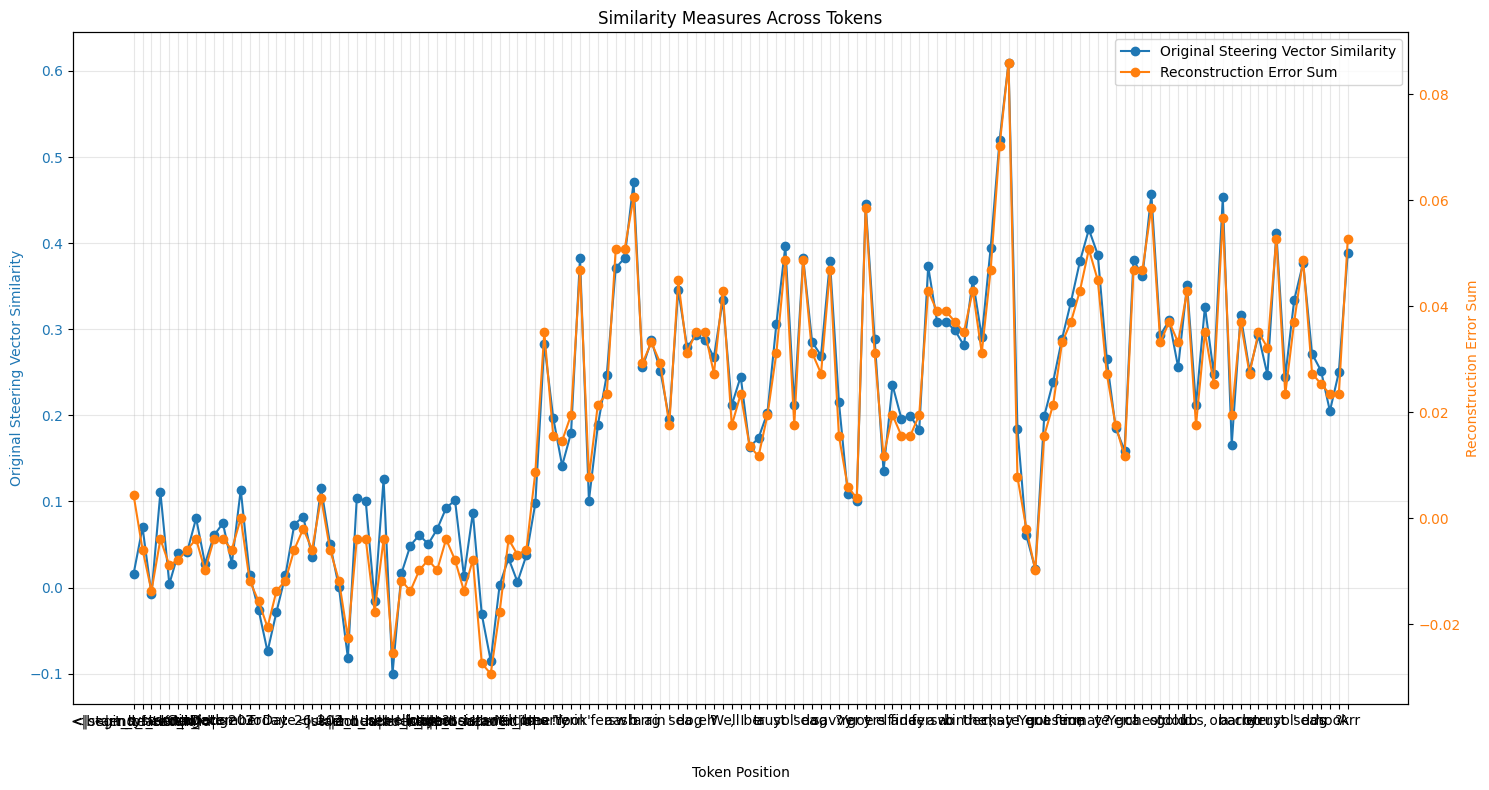

In [18]:
import matplotlib.pyplot as plt

# Create token labels
tokens = [model.tokenizer.decode(input_tokens[0][i]) for i in range(len(error_sims))]

# Create figure and axis with two different y-axes
fig, ax1 = plt.subplots(figsize=(15, 8))
ax2 = ax1.twinx()

# Plot on separate axes
line1 = ax1.plot(original_sims.cpu().float(), 
                 label='Original Steering Vector Similarity', 
                 marker='o', 
                 color='tab:blue')
line2 = ax2.plot(reconstruction_error_sum.detach().cpu().float(), 
                 label='Reconstruction Error Sum', 
                 marker='o', 
                 color='tab:orange')

# Set labels and title
ax1.set_xlabel('Token Position')
ax1.set_ylabel('Original Steering Vector Similarity', color='tab:blue')
ax2.set_ylabel('Reconstruction Error Sum', color='tab:orange')
plt.title('Similarity Measures Across Tokens')

# Combine legends
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels)

# Customize ticks
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')
plt.xticks(range(len(tokens)), tokens, rotation=45, ha='right')

# Add grid (only for primary axis to avoid clutter)
ax1.grid(True, alpha=0.3)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# They are highly correlated, and the sum cos sim of the error and reconstruction is centered around 0!

This is interesting. This implies that the reconstruction is capturing the original steering direction well, despite having very high error norm.

The cos sim sum of the error and reconstruction consistently centering around 0 during normal generation also implies that the error in the reconstruction is highly associated with some kind of omnipresent residual stream structure.

If it were a random error, we would expect to see the sum of the cos sims vary wildly.

# Next, I investigate the SAE latents of the error direction, as well as the error of the error.

This is a shot in the dark based on the high interpretability of the SAE latents in the original steering vector; however, it does not produce obviously interesting results.

error_direction_latents tensor([0.0991, 0.1040, 0.0080,  ..., 0.3223, 0.0771, 0.1299], device='cuda:0',
       dtype=torch.bfloat16, grad_fn=<IndexBackward0>)
error_squared norm tensor(190., device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<LinalgVectorNormBackward0>)
normed_error_direction norm tensor(1., device='cuda:0', dtype=torch.bfloat16,
       grad_fn=<LinalgVectorNormBackward0>)
error_direction_latents.shape torch.Size([65536])
Number of non-zero features: 44870

Feature descriptions:

Feature 21994 (0.422): Detection of "thing" token in "repeating same thing" instruction patterns

Feature 22491 (0.418): Instructions to avoid repeating content in responses

Feature 3394 (0.414): Instructions to avoid repetitive responses

Feature 15961 (0.402): Factual consistency checking between document and summary

Feature 52633 (0.402): System metadata marker for current date

Feature 41794 (0.393): Instructions to be concise and avoid repetition

Feature 7029 (0.379): Instructions t

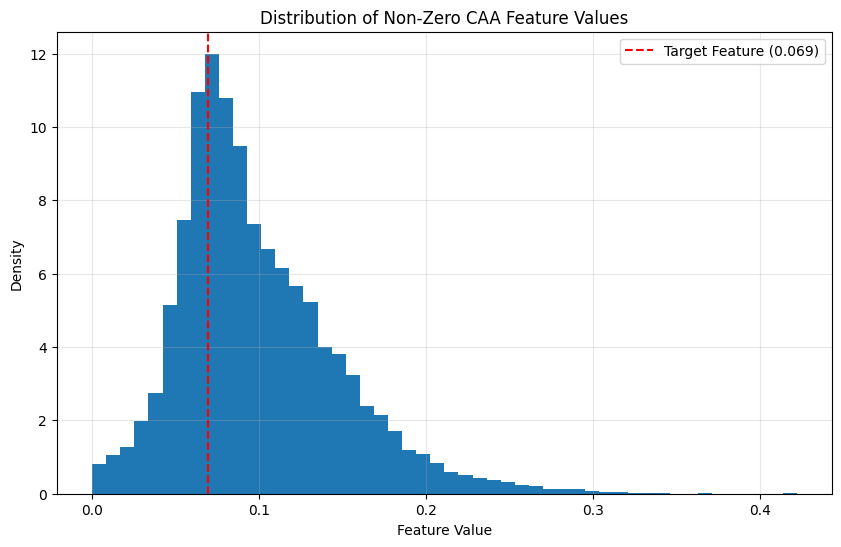

In [19]:
normed_error_direction = error_direction #/ torch.norm(error_direction)
error_direction_latents = sae.encode(normed_error_direction)
reconstructed_error_direction = sae.decode(error_direction_latents)
error_squared = error_direction - reconstructed_error_direction

print('error_direction_latents', error_direction_latents[error_direction_latents != 0])

print('error_squared norm', torch.norm(error_squared))
print('normed_error_direction norm', torch.norm(normed_error_direction))

print('error_direction_latents.shape', error_direction_latents[0].shape)

plot_feature_distribution(error_direction_latents[0].detach().cpu().float().numpy(), MODEL_NAME, client, pirate_feature_index, k=25)
